<a href="https://colab.research.google.com/github/AmmarSahyoun/AI-ProjektSubmission/blob/master/Clustering_Geolocation_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Geolocation Data 
### We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region. 

##  Objectives :
### -How the K-Means, DBSCAN, HDBSCAN works.
### -Density-based clustering approaches, and how to deal with any outliers.


## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength evaluate / Performance Metric

[**Task 4**](#task4): K-Means Clustering theory

[**Task 5**](#task5): DBSCAN density-based clustering approaches

[**Task 6**](#task6): HDBSCAN Used to alleviate constraints of classical DBSCAN

[**Task 7**](#task7): Addressing Outliers classified by density-based models

[**Further Reading**](#further)

In [69]:
# Required package for Colab
!pip install folium==0.11.0
!pip install tqdm==4.48.2
!pip install hdbscan==0.8.26

     |████████████████████████████████| 102kB 2.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.11.0 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


     |████████████████████████████████| 71kB 2.3MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


     |████████████████████████████████| 4.7MB 3.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2305932 sha256=99da22f8dc23fa71234356ddc38a538ceda75588b5c45ca326fb2ec290b1ba92
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [70]:
!pip show tqdm

Name: tqdm
Version: 4.48.2
Summary: Fast, Extensible Progress Meter
Home-page: https://github.com/tqdm/tqdm
Author: None
Author-email: None
License: MPLv2.0, MIT Licences
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: torchtext, thinc, tensorflow-datasets, spacy, pymc3, panel, moviepy, kaggle, hyperopt, gdown, featuretools, fa2


In [71]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [72]:
df = pd.read_csv('taxi_data.csv')
df.head(10)

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank
5  28.10125 -26.10605      Alexandra Main Taxi Rank
6  28.10185 -26.10537      Alexandra Main Taxi Rank
7  28.10165 -26.10479           Alexandra Taxi Rank
8  28.10151 -26.10594           Alexandra Taxi Rank
9  28.10200 -26.10576           Alexandra Taxi Rank

In [73]:
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [74]:
df.isna().values.any()

True

In [75]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [76]:
df.head(10)

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank
5  28.10125 -26.10605      Alexandra Main Taxi Rank
6  28.10185 -26.10537      Alexandra Main Taxi Rank
7  28.10165 -26.10479           Alexandra Taxi Rank
8  28.10151 -26.10594           Alexandra Taxi Rank
9  28.10200 -26.10576           Alexandra Taxi Rank

In [77]:
# create np.array that consist of LON+LAT
X = np.array(df[['LON', 'LAT']], dtype='float64')
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

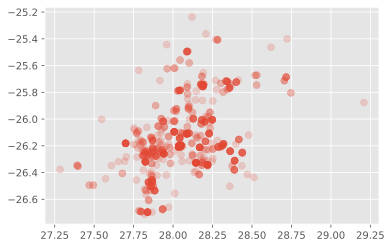

In [78]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [79]:
import folium 
import re       #Regular expression operations https://docs.python.org/3/library/re.html
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, 
               tiles='Stamen Toner') #center the map according to our data

for _, row in df.iterrows(): 
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),  #take the name and keep characters an spaces
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
    
m      # The circles represents the taxi ranks

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

In [80]:
# Generate isotropic Gaussian blobs for clustering. 
from sklearn.datasets import make_blobs   #(Create 1000 Dummy_samples with 10 clusters, 2Features and STD=0.5)
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, 
                        cluster_std=0.5, random_state=4)
X_blobs

array([[ -6.89867307,   2.31150542],
       [ -9.73185423,  -2.9970871 ],
       [ -5.37043025,  -1.50923072],
       ...,
       [  9.30620243,  -9.77320382],
       [  4.15014679,  -5.17853902],
       [-10.32190081,  -1.37670435]])

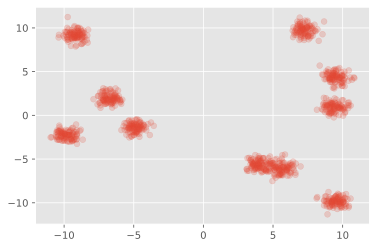

In [81]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

In [82]:
class_predictions = np.load('sample_clusters.npy')  #Read class predictions data of shape(1000,)
class_predictions #it shows the clusters numbers

array([2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0,

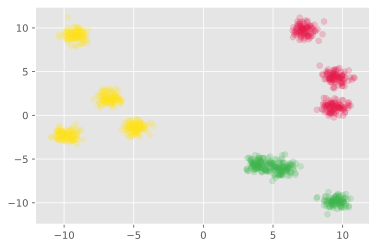

In [83]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [84]:
unique_clusters

array([0, 1, 2], dtype=int32)

In [85]:
# Selecting the number of clusters with silhouette_score
from sklearn.metrics import silhouette_score
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

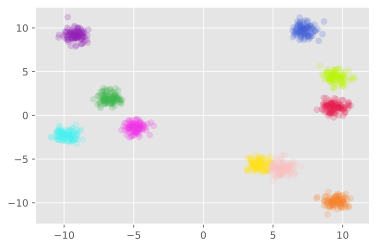

In [86]:
# Checkthe silhouette_score result with an improved data
class_predictions = np.load('sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [87]:
# this result is better beacause its closer to 1 
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

In [88]:
unique_clusters # new improved data

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

<a id='task4'></a>
# Task 4: HOW K-Means Clustering works and efficiency.

In [89]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, #(Create 1000 Dummy_samples with 10 clusters, 2Features, STD=1)
                        n_features=2, cluster_std=1, random_state=4)

In [90]:
from collections import defaultdict  #handel missing keys in dictionaries while accumulating operations
from sklearn.cluster import KMeans

data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [91]:
from ipywidgets import interactive #creates user interface controls for exploring code/data interactively.

def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

# running Kmeans for a few different iterations to see how it learns to cluster the data in an interactive way.
interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

### I need to find the optimal number of clusters k using 'silhouette_score' by creating a loop that iterates on range values of K.

In [92]:
from tqdm import tqdm    #make your loops show a smart progress meter 
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
            
print(f'K={best_k}')
print(f'The Best silhouette_Score: {best_silhouette} according to range 2 - {best_k} clusters ') 

100%|██████████| 98/98 [00:23<00:00,  4.26it/s]

K=19
The Best silhouette_Score: 0.41826309340774936 according to range 2 - 19 clusters 


### I can see that Silhouette_score increase when the number of  clusters increases! Let's try the 'Elbow method' to find the optimal number of clusters k regarding our dataset:

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


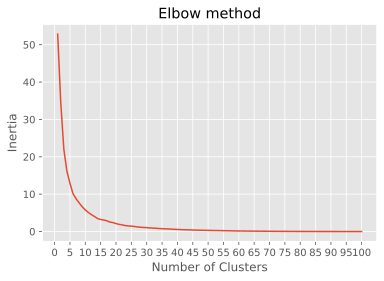

In [93]:
inertia=[]
for i in tqdm(range(1,101)):
    kmeans = KMeans(n_clusters=i,random_state=0).fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,101),inertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(0,101,5))
plt.show()

### I can see that there is no obvious elbow point using the elbow method.

In [97]:
# Let's fit our dataset to Kmeans, I will assume the number of cluster to 70.
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70   
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15
2  27.83239 -26.53722          Adams Road Taxi Rank                 5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18

In [98]:
# Let's visualize our result
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour,
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300948961482


In [99]:
m   # using Kmeans

###  ((Summary)) Kmeans algorithm aims to cluster iteratively the data BUT NEEDS to be told how many clusters K.     Kmeans algorithm starts with random values, and these can result in different clustering results even after many iterations.
### Since the elbow method and silhouette score fails in giving us the best number of clusters, this may mean that they are not sufficient to use with our data set.

<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [100]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])   #(-1 represent noise)

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])
# enumerate return the index_location and the value for the data
new   #gives a unique value to every(-1)

array([-2, -3, -4,  2,  3,  4,  5, -9])

In [101]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.01, min_samples=5).fit(X) #eps represent the radius and its hyperparameter
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [102]:
m = create_map(df, 'CLUSTERS_DBSCAN')

    
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette using outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette using outliers as singletons: 0.5667489350583482


In [103]:
m
# We can notice that DBSCAN treat different density point as they have the same density parameters, 
# which is a limitation of the DBSCAN algorithm.

### ((Summary)) DBSCAN algorithm has a global understanding of density. It can not take into account varying densities in the data, and may cluster them inefficiently.

<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [104]:
import hdbscan 
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [105]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette using outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette using outliers as singletons: 0.638992483305273


### ((Summary)) HDBSCAN is using the DBSCAN algorithm with different hyperparameters 'epsilon' to find different levels of density in the dataset.

<a id='task7'></a>
# Task 7: Addressing Outliers


### ((Summary)) Outliers, we have to define a way of dealing with them for our specific use case.                      Treating outliers as singletons is necessary, cause it allows the Silhouette Score to give a score to the whole clustering result, not just the samples that were indeed clustered.


In [106]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1) #n_neighbors: hyperparameters that chooses the best value 

In [107]:
# Split our data into train and test, and assign the clustered data to train.
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [108]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [109]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [110]:
predictions = classifier.predict(X_predict)

In [111]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [112]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [113]:
m = create_map(df, 'CLUSTER_hybrid')
m

### We can see that certain points were been clustered in a certain way in a density-based approach and that quit useful in our business problem, where we may build a big service center in an area that has large density ranks of taxis which Kmeans does not take it in account. Kmeans could potentially create large clusters.

In [114]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 0, 'Cluster Sizes')

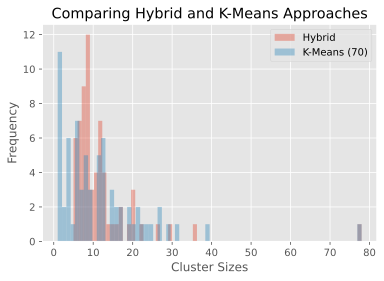

In [115]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')

### We can see that the density-based approach has more value and more large density clustered

<a id='further'></a>
# Further Reading

For some additional reading, feel free to check out [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering respectively.

It may be of use to also check out [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) that are commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.